1


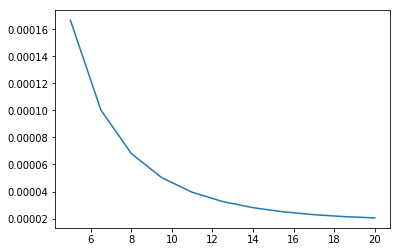

In [26]:
import numpy as np
import matplotlib.pyplot as plt

t=np.arange(0.01,0.02,0.01)
poissons_ratio = 0.20
E = 0.2 
Inner_radius = 5
outer_radius = 20
n = 10
mu = E/(2*(1+poissons_ratio))
Lambda=poissons_ratio*E/((1-2*poissons_ratio)*(1+poissons_ratio))
volumetric_strain = -0.01
yield_stress = 200e-6 #N/micromm^2
C = np.array([[Lambda+2*mu,Lambda,Lambda],
              [Lambda,Lambda+2*mu,Lambda],
              [Lambda,Lambda,Lambda+2*mu]])
coordinate = np.linspace(Inner_radius,outer_radius,n+1)
#print(coordinate)

Global_K = np.zeros((n+1,n+1))   # Zero matrix of order (n+1,n+1) for adding elemental stiffness
Global_F_ext = np.zeros((n+1,1))
delta_u = 1

plastic_strain = np.zeros((n,3,1))

d = np.linspace(0,(1/3*t[0]*(-volumetric_strain)*coordinate[0]),n+1).reshape(n+1,1) #Initial guess
  
Global_displacement = np.flip(d,0)   
#print(Global_displacement)
Reduced_displacement = np.delete(Global_displacement,(0),axis=0)


for time,tau in enumerate(t):
    Global_displacement[0]=1/3*tau*(-volumetric_strain)*Inner_radius
    print(time+1)
    while np.linalg.norm(delta_u)>(0.005*np.linalg.norm(Reduced_displacement)):
        for i in range(len(coordinate)-1):


            def element_routine(coordinate,Lambda,mu,tau):
                Derivative_N = np.array([-1/2,1/2])
                Jacobian = Derivative_N@np.array([[coordinate[i]],
                                                  [coordinate[i+1]]])
                J_inv = np.asscalar(1/Jacobian)

                B = np.array([[-1/2*J_inv,1/2*J_inv],
                              [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])],
                              [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])]])


                B_T = np.transpose(B)
                Element_stiffness = 2*(B_T@material_routine(E)@B)*Jacobian*((coordinate[i]+coordinate[i+1])/2)**2

                #External force calculation
                sigma_rr = 2*mu*J_inv*((-Global_displacement[i]+Global_displacement[i+1])/2)+Lambda*tau*volumetric_strain

                Fe = np.array([[-np.asscalar(sigma_rr)*coordinate[i]**2],
                                [np.asscalar(sigma_rr)*coordinate[i+1]**2]])
                #print(Fe)
                return Element_stiffness


            def material_routine(E):
                Derivative_N = np.array([-1/2,1/2])
                Jacobian = Derivative_N@np.array([[coordinate[i]],
                                                  [coordinate[i+1]]])
                J_inv = np.asscalar(1/Jacobian)

                B_matrix = np.array([[-1/2*J_inv,1/2*J_inv],
                              [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])],
                              [1/(coordinate[i]+coordinate[i+1]),1/(coordinate[i]+coordinate[i+1])]])

                Current_strain = B_matrix@np.array([Global_displacement[i],Global_displacement[i+1]]) 


                Trial_stress = C@(Current_strain - plastic_strain[i])
                Trial_dev = Trial_stress - 1/3*np.sum(Trial_stress)
                Trial_eq = np.sqrt(3/2*(np.sum(np.square(Trial_dev))))

                if Trial_eq - yield_stress <= 0:
                    return C
                else:
                    del_lamda = (Trial_eq - yield_stress)/E
                    plastic_strain[i] = plastic_strain[i] + del_lamda * 1.5 * (Trial_dev/Trial_eq)
                    new_stress = C@(Current_strain-plastic_strain[i])


            Ke = element_routine(coordinate,Lambda,mu,tau) 

            #Assignmnet matrix
            Ae = np.zeros((2,n+1))
            Ae[0,i]=1                                            # [0,n-1]=1 [1,n]=1
            Ae[1,i+1]  =1
            AeT = np.transpose(Ae)


            #Global stiffness matrix
            K=AeT@Ke@Ae                                          # Stiffness matrix  of each element after transformation
            Global_K = np.add(Global_K,K)  # Global stiffnes matrix
          
            K_red = np.delete(Global_K,(0),axis=0)
            K_red = np.delete(K_red,(0),axis=1)



           #F_ext = AeT@Fe_ext                                   # Force vector of each element after transformation
           #Global_F_ext=np.add(Global_F_ext,F_ext)              # Global F matrix
            Global_F_ext = np.zeros((n+1,1))
           #print(Global_F_ext)
            Global_F_ext[-1]=0                                   # Global F matrix

           



        #Newton Raphson method

        #print(Global_K)
        G_matrix = Global_K@Global_displacement - Global_F_ext

        G_red = np.delete(G_matrix,(0),axis=0)
        delta_u = np.linalg.inv(K_red)@G_red
        Reduced_displacement = Reduced_displacement - delta_u
        Global_displacement = np.insert(Reduced_displacement,(0),(1/3*(tau)*(-volumetric_strain)*Inner_radius)).reshape(n+1,1)
    plt.plot(coordinate,Global_displacement)

coordinate = coordinate + (Global_displacement.reshape(1,n+1))

 



       
   
   
    